In [1]:
# https://data.worldbank.org/indicator/FI.RES.TOTL.CD

In [64]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as skmet
from sklearn.cluster import KMeans
import scipy.optimize as opt
import numpy as np
import errors

In [3]:
def worldbank_data(filename):
    """
    Imports World Bank data.

    Returns:
    - Original Data.
    - Transposed Data.
    """    
    df = pd.read_csv(filename, skiprows=4)
    df_T = df.set_index(df.columns[0]).transpose()
    
    return df, df_T

In [8]:
df, df_T = worldbank_data('API_FI.RES.TOTL.CD_DS2_en_csv_v2_6298254.csv')

In [9]:
df.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Total reserves (includes gold, current US$)",FI.RES.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.803510e+08,8.158006e+08,9.225509e+08,9.071115e+08,9.802477e+08,9.823000e+08,1.212579e+09,1.512960e+09,1.543941e+09,NaN
1,Africa Eastern and Southern,AFE,"Total reserves (includes gold, current US$)",FI.RES.TOTL.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Total reserves (includes gold, current US$)",FI.RES.TOTL.CD,50690800.0,42444500.0,40592100.0,45547800.0,44619680.0,45434560.0,...,7.528550e+09,6.976966e+09,7.281911e+09,8.097281e+09,8.206682e+09,8.497656e+09,9.748946e+09,NaN,NaN,NaN


In [21]:
columns_to_select = ['Country Name', 'Indicator Name'] + list(map(str, range(2000, 2023)))
df_sub = pd.DataFrame()
for column in columns_to_select:
    df_sub[column] = df[column]
df_sub = df_sub.dropna()
df_subx = pd.DataFrame()
df_subx["Country Name"] = df_sub["Country Name"]
df_subx["2022"] = df_sub["2022"].copy()

In [22]:
df_subx["Growth Since 2000 (%)"] = 100.0 * (df["2022"] - df["2000"]) / (df["2000"])
df_subx.head()

,Country Name,2022,Growth Since 2000 (%)
0,Aruba,1.543941e+09,555.726398
4,Angola,1.365472e+10,1039.590614
5,Albania,5.266464e+09,714.856464
8,United Arab Emirates,1.384333e+11,915.530817
9,Argentina,4.479534e+10,78.097672


In [73]:
z_scores = (df_subx[['2022', 'Growth Since 2000 (%)']] - df_subx[['2022', 'Growth Since 2000 (%)']].mean()) / df_subx[['2022', 'Growth Since 2000 (%)']].std()
threshold = 3
df_subx = df_subx[(np.abs(z_scores) < threshold).all(axis=1)]

In [74]:
df_subx.describe()

,2022,Growth Since 2000 (%)
count,1.410000e+02,141.000000
mean,6.617499e+10,803.901558
std,1.405473e+11,790.775753
min,4.860669e+07,-57.074931
25%,2.216592e+09,283.649169
50%,8.761701e+09,544.757757
75%,5.670190e+10,1068.713715
max,9.236275e+11,4113.603184


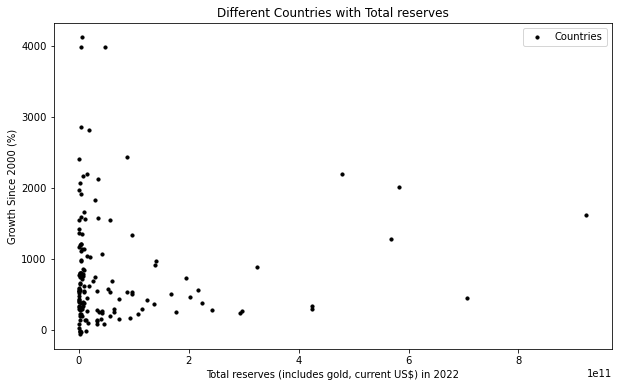

In [75]:
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(df_subx["2022"], df_subx["Growth Since 2000 (%)"], 10, label="Countries", c='black')
plt.xlabel("Total reserves (includes gold, current US$) in 2022")
plt.ylabel("Growth Since 2000 (%)")
plt.title("Different Countries with Total reserves")
plt.legend()
plt.show()

In [76]:
def data_norm(data_frame, features):
    """
    Function to normalize the specified features using StandardScaler.

    Returns:
    - Normalized DataFrame.
    """
    scaler = RobustScaler()
    subset_features = data_frame[features]
    scaler.fit(subset_features)
    normalized_data = scaler.transform(subset_features)
    normalized_df = pd.DataFrame(normalized_data, columns=features)

    return normalized_df, scaler

In [77]:
df_norm, scaler = data_norm(df_subx, ['2022', 'Growth Since 2000 (%)'])

In [78]:
df_norm.head()

,2022,Growth Since 2000 (%)
0,-0.132472,0.013972
1,0.089804,0.630309
2,-0.064150,0.216668
3,2.379937,0.472284
4,0.661346,-0.594423


In [79]:
def silhouette_score(xy, n):
    """
    Calculates silhouette score for n clusters using KMeans++ initialization.

    Returns:
    Silhouette score.
    """
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10)
    kmeans.fit(xy)
    labels = kmeans.labels_
    score = skmet.silhouette_score(xy, labels)
    return score

In [80]:
for i in range(2, 10):
    score = silhouette_score(df_norm, i)
    print(f"The silhouette score for {i: 3d} is {score: 7.4f}")

The silhouette score for   2 is  0.7829
The silhouette score for   3 is  0.5972
The silhouette score for   4 is  0.5535
The silhouette score for   5 is  0.5593
The silhouette score for   6 is  0.5157
The silhouette score for   7 is  0.4851
The silhouette score for   8 is  0.5052
The silhouette score for   9 is  0.4450


In [82]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20)
kmeans.fit(df_norm)
labels = kmeans.labels_
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
xkmeans, ykmeans = centroids[:, 0], centroids[:, 1]

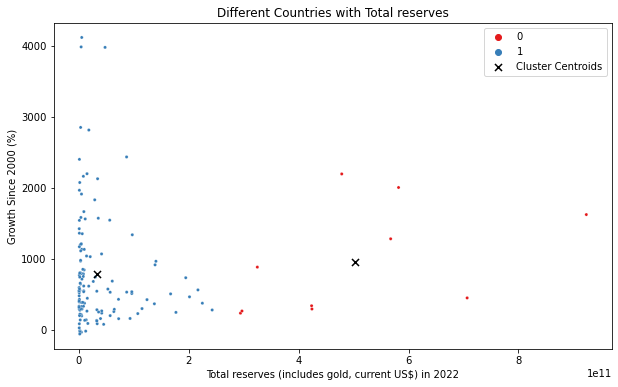

In [91]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_subx["2022"], y=df_subx["Growth Since 2000 (%)"], hue=labels, palette="Set1", marker="o", s=10)
plt.scatter(xkmeans, ykmeans, marker="x", c="black", s=50, label="Cluster Centroids")
plt.xlabel("Total reserves (includes gold, current US$) in 2022")
plt.ylabel("Growth Since 2000 (%)")
plt.title("Different Countries with Total reserves")
plt.legend()
plt.show()

In [84]:
df_uk = df_T.loc['2000':'2022', ['United Kingdom']].reset_index()
df_uk = df_uk.rename(columns={'index': 'Year', 'United Kingdom': 'UK Reserves'})
df_uk = df_uk.apply(pd.to_numeric, errors='coerce')
df_uk.describe()

Country Name,Year,UK Reserves
count,23.00000,2.300000e+01
mean,2011.00000,1.093758e+11
std,6.78233,4.904978e+10
min,2000.00000,4.741747e+10
25%,2005.50000,6.298089e+10
50%,2011.00000,1.097339e+11
75%,2016.50000,1.494835e+11
max,2022.00000,1.941814e+11


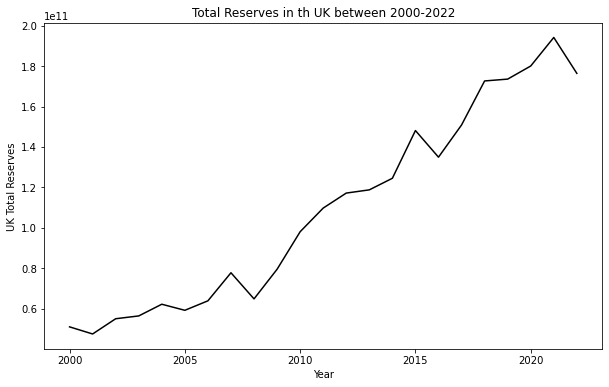

In [85]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = df_uk, x='Year', y='UK Reserves', color='black')
plt.xlabel('Year')
plt.ylabel('UK Total Reserves')
plt.title('Total Reserves in th UK between 2000-2022')
plt.show()

In [86]:
def exponential(t, n0, g):
    """Calculates exponential function with scale factor n0 and growth rate g."""
    # makes it easier to get a guess for initial parameters
    t = t - 2010
    f = n0 * np.exp(g*t)
    return f

In [87]:
param, covar = opt.curve_fit(exponential, df_uk["Year"], df_uk["UK Reserves"], p0=(1e11, 0.1))
df_uk["fit"] = exponential(df_uk["Year"], *param)

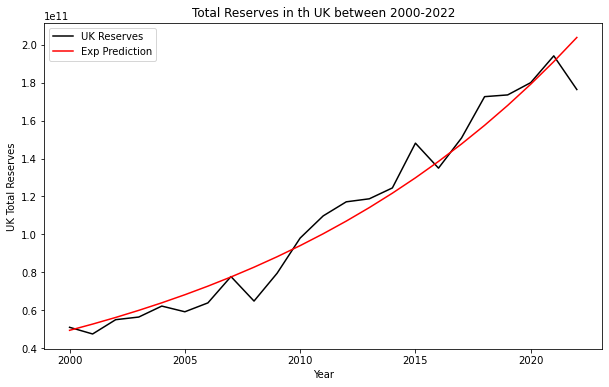

In [88]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_uk, x="Year", y="UK Reserves", label="UK Reserves", color='black')
sns.lineplot(data=df_uk, x="Year", y="fit", label="Exp Prediction", color='red')
plt.xlabel('Year')
plt.ylabel('UK Total Reserves')
plt.title('Total Reserves in th UK between 2000-2022')
plt.legend()
plt.show()

In [89]:
import errors
years = np.arange(2022, 2034, 1)
predictions = exponential(years, *param)
confidence_range = errors.error_prop(years, exponential, param, covar)

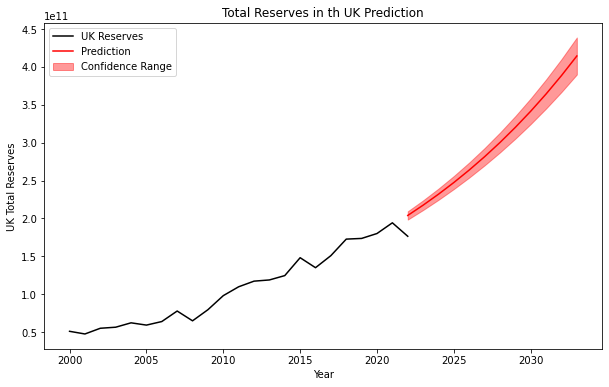

In [90]:
plt.figure(figsize=(10, 6))
sns.lineplot(x= df_uk["Year"], y= df_uk["UK Reserves"], label="UK Reserves", color='black')
sns.lineplot(x=years, y=predictions, label="Prediction", color='red')
plt.fill_between(years, predictions - confidence_range, predictions + confidence_range, 
                 color='red', alpha=0.4, label="Confidence Range")
plt.xlabel('Year')
plt.ylabel('UK Total Reserves')
plt.title('Total Reserves in th UK Prediction')
plt.legend()
plt.show()